In [293]:
import quandl as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import seaborn as sns
sns.set_theme()

In [269]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.dummy import DummyClassifier

In [294]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load Data

In [3]:
def load_data(ticker='msft'):
    with pd.HDFStore('data.h5') as store:
        data = store['model_data/{}'.format(ticker)]
    return data
    

In [4]:
ticker='msft'

In [5]:
data = load_data(ticker)

## Create Model data

In [6]:
def model_data(data):
    
    OHLCV = ['open', 'close', 'low', 'high', 'volume']
    X = data.drop(OHLCV, axis=1)
    X = X.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)
    y = data.filter(like='target')
    X = X.drop(y.columns, axis=1)
    
    return X,y

In [7]:
X,labels = model_data(data)

In [8]:
labels.head()

,target_1d,target_5d,target_10d,target_21d
Date,,,,
2010-07-06,0.019951,0.053537,0.067368,0.077132
2010-07-07,0.004516,0.045846,0.033188,0.043091
2010-07-08,-0.005751,0.044078,0.056931,0.045645
2010-07-09,0.022812,0.025225,0.061521,0.053742
2010-07-12,0.012009,0.015981,0.049883,0.009619


In [9]:
horizon = 1 #set prediction horizon

target = 'target_{}d'.format(horizon)

y = np.sign(labels[target])
y.value_counts()

 1.0    1631
-1.0    1468
 0.0      26
Name: target_1d, dtype: int64

In [12]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=.2, shuffle=False)

X_train.shape

(2500, 22)

In [13]:
X_test.shape

(625, 22)

In [14]:
year = 252 # there are roughly 252 trading day in a year
test_period_size = 10
n_splits = 100

In [15]:
tsplit = TimeSeriesSplit(n_splits=n_splits,
                         max_train_size=year,
                         test_size=test_period_size,
                         gap=1)

In [16]:
scores = {}

In [17]:

#for fold, (train_idx, val_idx) in enumerate(tsplit.split(X_train)):
    #print(fold, train_idx, val_idx)

In [18]:
def param_compare(grid):
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(results_df["params"]
                                      .apply(lambda x: "_".join(str(val) for val in x.values())))
    return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

## Model : Dummy classifier

In [270]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [271]:
dummy_scores = cross_val_score(dummy_clf, X_train, y_train, cv=tsplit, scoring="accuracy")
np.average(dummy_scores)

0.562

In [274]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [272]:
scores.update({"dummy_clf": dummy_scores})

In [275]:
y_pred_dummy = dummy_clf.predict(X_test)

In [276]:
accuracy_score(y_pred_dummy, y_test)

0.512

## Model : Logistic Regression

In [19]:
import joblib

In [20]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [21]:
log_clf_scores = cross_val_score(log_clf, X_train,
                         y_train,cv=tsplit,
                         scoring='accuracy')

In [23]:
np.average(log_clf_scores)

0.534

In [24]:
scores.update({'log_clf':log_clf_scores})

In [25]:
log_params = { 'logisticregression__C' : np.logspace(-5,5,11), 
              'logisticregression__solver': ['liblinear', 'saga'], 
              'logisticregression__penalty' : ['l1', 'l2']}

In [26]:
log_grid = GridSearchCV(log_clf, param_grid= log_params, scoring='accuracy', cv=tsplit)

In [27]:
log_grid.fit(X_train, y_train)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [28]:
log_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [29]:
y_pred_log = log_grid.best_estimator_.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred_log)

0.4992

In [70]:
joblib.dump(log_reg, "log_reg.pkl")

['log_reg.pkl']

In [289]:
#param_compare(log_grid)

## Model : Support Vector Machine

In [32]:
from sklearn.svm import SVC,LinearSVC

In [33]:
svm_clf = make_pipeline(StandardScaler(), SVC())

In [34]:
svm_clf_scores = cross_val_score(svm_clf, X_train,
                         y_train,cv=tsplit,
                         scoring='accuracy')

In [35]:
np.average(svm_clf_scores)

0.5469999999999999

In [36]:
scores.update({'svm_clf': svm_clf_scores})

In [37]:
svc_params = {
    'svc__C': np.logspace(-5,5,11),
    'svc__gamma': [0.1,1,10,100],
}

In [38]:
svc_grid = GridSearchCV(svm_clf, param_grid=svc_params, scoring='accuracy', cv=tsplit)

In [39]:
svc_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'svc__gamma': [0.1, 1, 10, 100]},
             scoring='accuracy')

In [40]:
svc_grid.best_score_

0.562

In [41]:
y_pred_svm = svc_grid.best_estimator_.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred_svm)

0.512

## Model : Random forest

In [184]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                n_jobs = -1)

In [186]:
rnd_clf_scores = cross_val_score(rnd_clf, X_train, y_train, cv=tsplit, scoring="accuracy")


In [187]:
np.average(rnd_clf_scores)

0.5319999999999999

In [188]:
scores.update({'rnd_clf': rnd_clf_scores})

In [189]:
rf_params = [
    {'n_estimators': [10, 50,100,200], 
     'max_features': [5, 10, 20], 
 'max_depth': [10,20,30], 
     'bootstrap': [True, False]}
]



In [190]:
rf_grid = GridSearchCV(rnd_clf, param_grid=rf_params, scoring='accuracy', cv=tsplit, n_jobs= -1)

In [191]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=RandomForestClassifier(max_leaf_nodes=16,
                                              n_estimators=500, n_jobs=-1),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                          'max_features': [5, 10, 20],
                          'n_estimators': [10, 50, 100, 200]}],
             scoring='accuracy')

In [192]:
y_pred_rf = rf_grid.best_estimator_.predict(X_test)

In [193]:
accuracy_score(y_test, y_pred_rf)

0.5104

In [55]:
for name, score in zip(X_test.columns,rf_grid.best_estimator_.feature_importances_):
    print(name, score)

rsi 0.059261109168540396
bb_high 0.05257137846636262
bb_low 0.07709336032274033
atr 0.14268065076213796
macd 0.11745397020761429
return_1d 0.10442646672728909
return_5d 0.06241106100427203
return_10d 0.15103864265456293
return_21d 0.055679684860323576
return_42d 0.09080503230364538
return_63d 0.0551154437593586
month_2 0.0020818116045634187
month_3 0.0021934406982886704
month_4 0.0
month_5 0.0019470390398431139
month_6 0.0034461336460777188
month_7 0.005561910543941963
month_8 0.001699564682667892
month_9 0.002820834284712696
month_10 0.0026800686949176814
month_11 0.003896326091247147
month_12 0.005136070476892608


## Model : Neural Network

In [194]:
from sklearn.neural_network import MLPClassifier

In [195]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000, random_state=42)

In [196]:
neural_clf = make_pipeline(StandardScaler(), mlp_clf)

In [197]:
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=tsplit, scoring='accuracy')

In [198]:
scores.update({'nn_clf': neural_scores})

In [199]:
np.average(neural_scores)

0.502

In [200]:
neural_params = {
    'mlpclassifier__activation' : ['logistic', 'tanh', 'relu'],
    'mlpclassifier__alpha' : [0.001,0.01,0.1,10],
}

In [201]:
neural_grid = GridSearchCV(neural_clf, param_grid=neural_params, cv=tsplit, scoring='accuracy')

In [202]:
neural_grid.fit(X_train,y_train)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=(50,
                                                                          50,
                                                                          50),
                                                      max_iter=1000,
                                                      random_state=42))]),
             param_grid={'mlpclassifier__activation': ['logistic', 'tanh',
                                                       'relu'],
                         'mlpclassifier__alpha': [0.001, 0.01, 0.1, 10]},
             scoring='accuracy')

In [204]:
neural_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=10,
                               hidden_layer_sizes=(50, 50, 50), max_iter=1000,
                               random_state=42))])

In [205]:
neural_grid.best_score_

0.562

In [206]:
y_pred_nn = neural_grid.best_estimator_.predict(X_test)

In [207]:
accuracy_score(y_test, y_pred_nn)

0.512

## Ensemble

- voting classifier

In [215]:
from sklearn.ensemble import VotingClassifier

In [216]:
voting_clf = VotingClassifier(estimators=[('lr', lg_clf),
                                          ('rf', rf_clf),
                                         ('sv', sv_clf),
                                         ('nn', n_clf)],
                             voting='hard')

In [217]:
voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=tsplit, scoring='accuracy')

In [218]:
scores.update({'voting_clf': voting_scores})

In [219]:
voting_clf.fit(X_train.iloc[-252:], y_train.iloc[-252:])

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.1,
                                                                  max_iter=1000,
                                                                  penalty='l1',
                                                                  solver='saga'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=30,
                                                     max_features=5,
                                                     max_leaf_nodes=16,
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                             ('sv',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=1e-05, gamma=0.1))])),
                             ('nn',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('mlpclassifier',
                                               MLPClassifier(activation='tanh',
                                                             alpha=10,
                                                             hidden_layer_sizes=(50,
                                                                                 50,
                                                                                 50),
                                                             max_iter=1000,
                                                             random_state=42))]))])

In [220]:
y_pred_vote = voting_clf.predict(X_test)

In [221]:
accuracy_score(y_test, y_pred_vote)

0.5104

### Adaptive Boosting

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [151]:
ada_clf = AdaBoostClassifier()

In [152]:
ada_scores = cross_val_score(ada_clf, X_train, y_train, scoring='accuracy', cv=tsplit)

In [224]:
scores.update({'adaboost': ada_scores})

In [153]:
np.average(ada_scores)

0.5009999999999999

In [154]:
ada_params = {
    #'estimator__max_depth': [5,10,15,20],
    #'estimator__max_features': [2,5,10,20],
    #'max_leaf_nodes': [2,4,8,16,24],
    'learning_rate': [0.01,0.1,0.2,0.5,1],
    'n_estimators': [10,20,40,100,150,200,500]
}

In [157]:
ada_grid = GridSearchCV(ada_clf,param_grid=ada_params,
                       cv=tsplit, scoring='accuracy', n_jobs=-1)

In [158]:
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [10, 20, 40, 100, 150, 200, 500]},
             scoring='accuracy')

In [160]:
y_pred_ada = ada_grid.best_estimator_.predict(X_test)

In [161]:
accuracy_score(y_pred_ada, y_test)

0.5008

### Gradient Boosting

In [162]:
from sklearn.ensemble import GradientBoostingClassifier

In [70]:
from xgboost import XGBClassifier

In [169]:
grb_clf = GradientBoostingClassifier()

In [170]:
grb_scores = cross_val_score(grb_clf, X_train,
                             y_train,
                            scoring= 'accuracy',
                            cv=tsplit)

In [225]:
scores.update({'gradboost': grb_scores})

In [171]:
np.average(grb_scores)

0.5359999999999999

In [172]:
grb_params = {
    "max_depth" : [2,4,8,16,20],
    "n_estimators": [1,2,4,8,16,32,64,128,200],
    "learning_rate": [0.01,0.2,0.5,0.1,1,10],
}

In [175]:
grb_grid = GridSearchCV(grb_clf, param_grid=grb_params,
                       cv=tsplit,
                       scoring="accuracy", n_jobs=-1)

In [176]:
grb_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=252, n_splits=100, test_size=10),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2, 0.5, 0.1, 1, 10],
                         'max_depth': [2, 4, 8, 16, 20],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 200]},
             scoring='accuracy')

In [178]:
y_pred_grb = grb_grid.best_estimator_.predict(X_test)

In [179]:
accuracy_score(y_test, y_pred_grb)

0.512

## preserve model statistics and final results

In [226]:
lg_clf = log_grid.best_estimator_
sv_clf = svc_grid.best_estimator_
rf_clf = rf_grid.best_estimator_
n_clf = neural_grid.best_estimator_
adaboost = ada_grid.best_estimator_
grbboost = grb_grid.best_estimator_

In [278]:
models = {'log_clf': lg_clf,
          'svm_clf': sv_clf,
          'rnd_clf': rf_clf,
          'mlp_clf': n_clf,
          'vot_clf':voting_clf,
          'ada_clf': adaboost,
          'grb_clf': grbboost,
          'dummy_clf': dummy_clf}

In [279]:
def save_results(data, X_test,target, models, ticker):
    
    test_set = data.loc[data.year == 2021]
    test_set['direction'] = np.sign(test_set[target]).astype(int)
    for model in  models.keys():
        #test_set[model] = model.predict(X_test)
        test_set[model] = test_set[target] * models[model].predict(X_test.loc["2021-01-04": "2021-12-31"])
    test_set.to_hdf('data.h5', 'models/test_result/{}'.format(ticker))
    return test_set

In [280]:
test_results = save_results(data,X_test,target,models,ticker)

/tmp/ipykernel_336178/1766898786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['direction'] = np.sign(test_set[target]).astype(int)
/tmp/ipykernel_336178/1766898786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[model] = test_set[target] * models[model].predict(X_test.loc["2021-01-04": "2021-12-31"])
/tmp/ipykernel_336178/1766898786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## Comparison of strategies

### 1. comparing returns

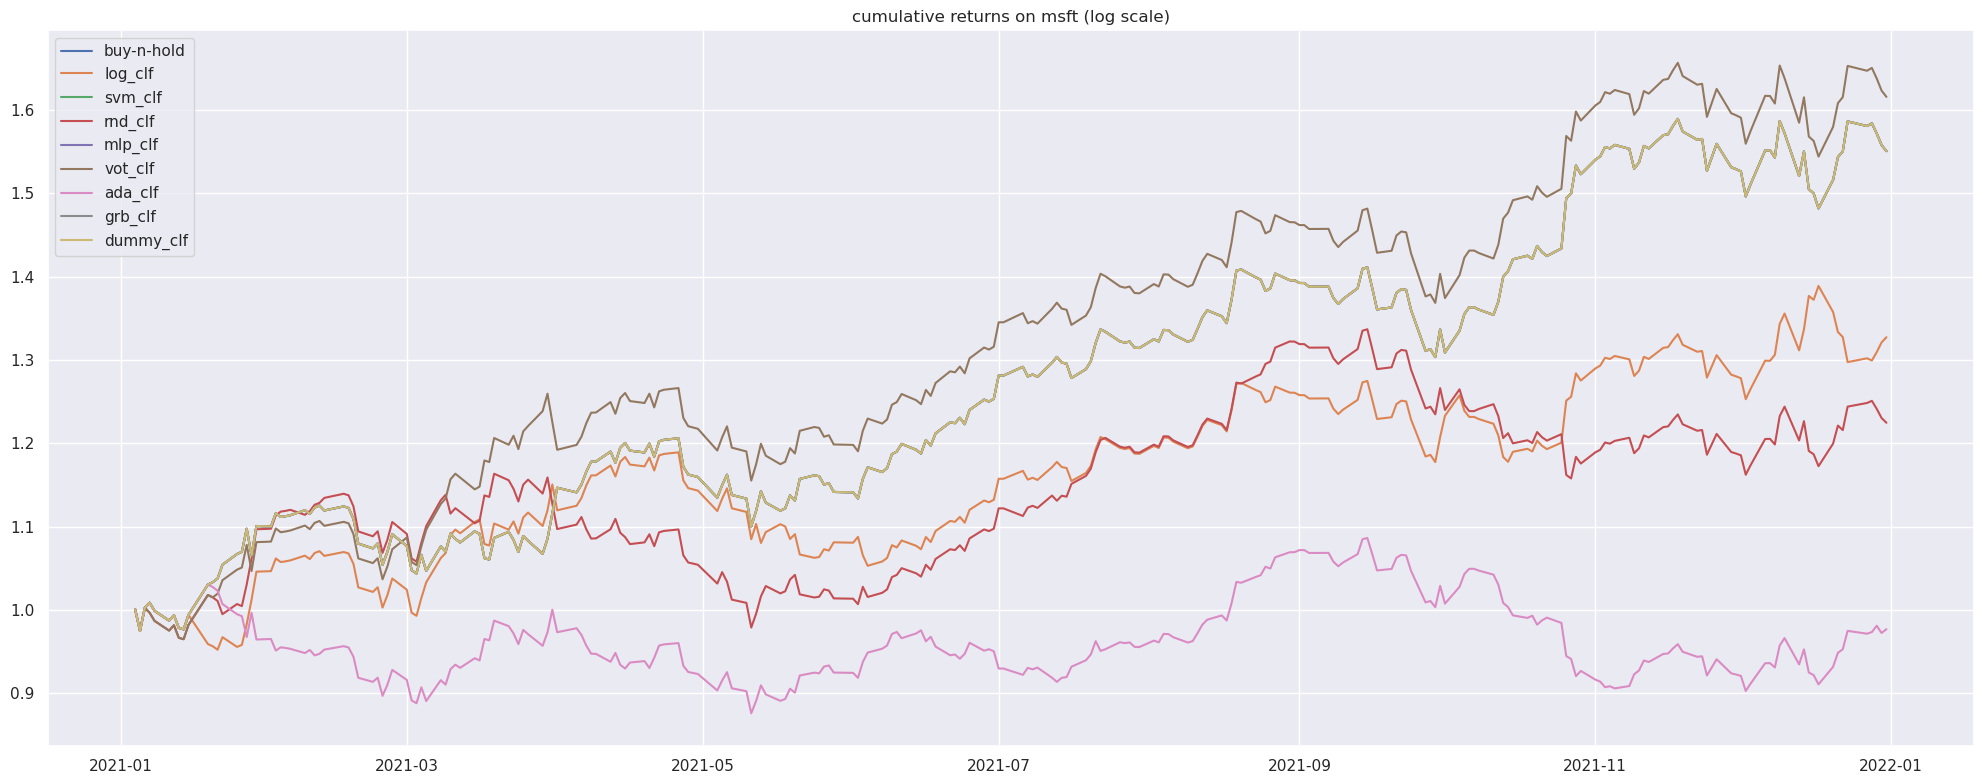

In [295]:
fig,ax = plt.subplots(figsize=(20,8))

plt.plot(test_results[[target]].cumsum().apply(np.exp), label='buy-n-hold')
for model in models.keys():
    plt.plot(test_results[[model]].cumsum().apply(np.exp), label = model)
plt.legend()
plt.title('cumulative returns on {} (log scale)'.format(ticker))
save_fig("returns_{}".format(ticker))
plt.show()

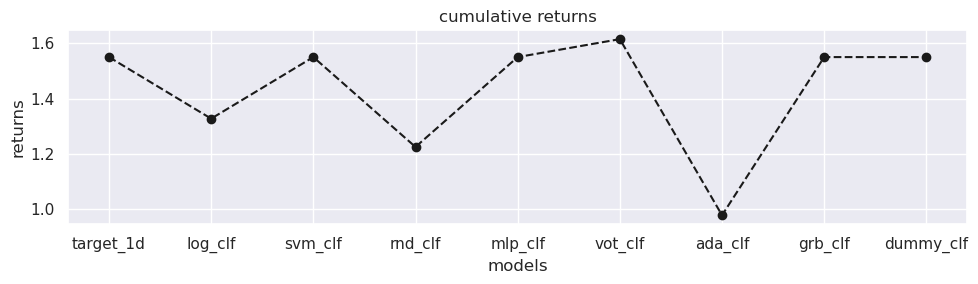

In [296]:
cum_returns = test_results[[target] + list(models.keys())].sum().apply(np.exp)
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(cum_returns, 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("cumulative returns")
plt.xlabel('models')
plt.ylabel('returns')
save_fig("returns_dist_{}".format(ticker))
plt.show()

### 2. comparing models

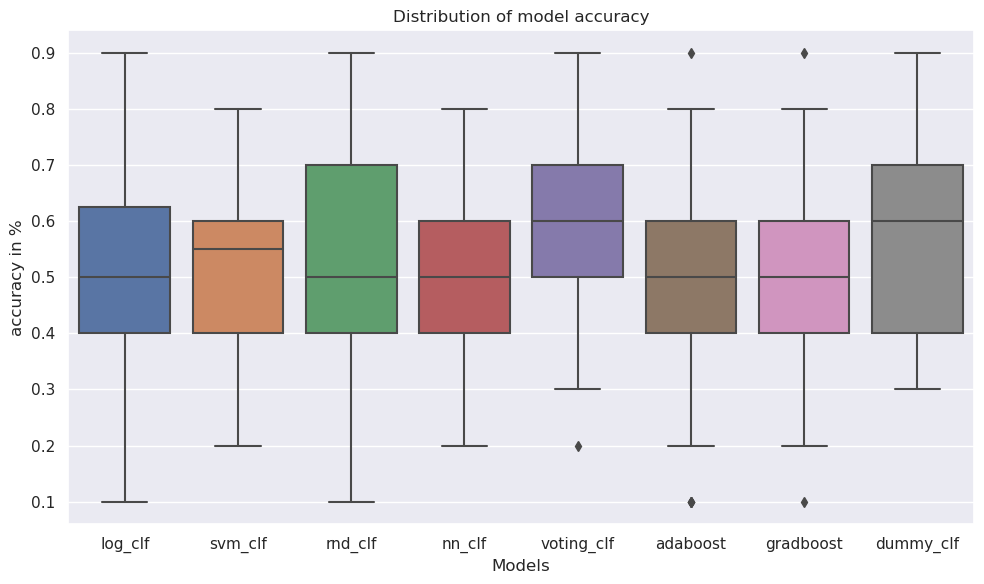

In [297]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=pd.DataFrame(scores), ax = ax)
plt.title('Distribution of model accuracy')
ax.set_xlabel("Models")
ax.set_ylabel("accuracy in %")
#plt.legend()
save_fig("accuracy_valid_{}".format(ticker))
plt.show()

In [284]:
accuracy_test = {}
for model in models.keys():
    accuracy_test.update({model: accuracy_score(y_test,models[model].predict(X_test))})
    

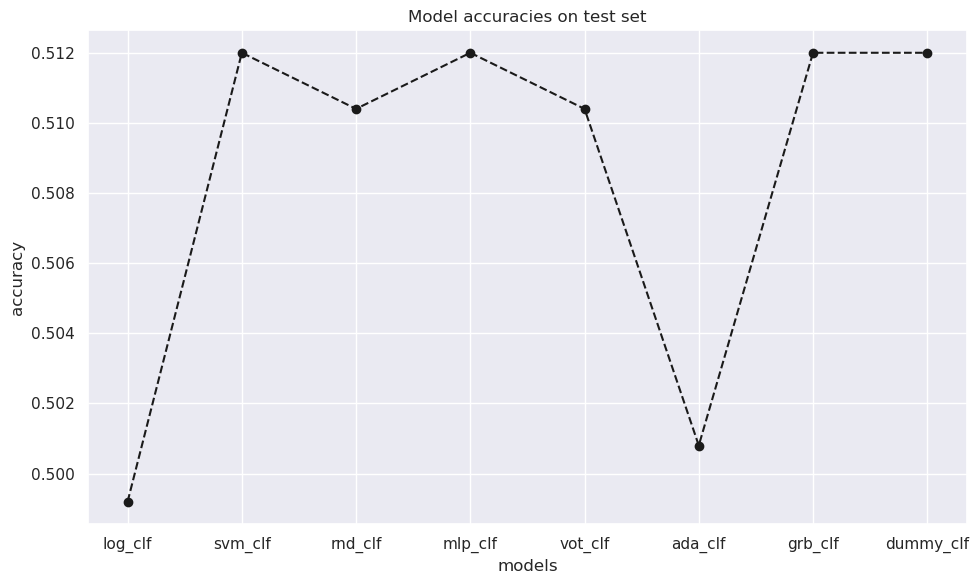

In [298]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(pd.Series(accuracy_test), 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("Model accuracies on test set")
plt.xlabel('models')
plt.ylabel('accuracy')
save_fig("accuracy_dist_{}".format(ticker))
plt.show()

In [287]:
y_test.value_counts()

 1.0    320
-1.0    303
 0.0      2
Name: target_1d, dtype: int64